# Semantic Correspondence with DINOv2

## 1. Environment Detection and Setup

In [ ]:
# detect if running in Google Colab or locally
import sys
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab environment")
except ImportError:
    IN_COLAB = False
    print("Running in Local environment")

In [ ]:
# mount Google Drive (Colab) or set local path
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_ROOT = Path('/content/drive/MyDrive/SemanticCorrespondenceDrive')
    !pip install -q torch torchvision timm tqdm scikit-image matplotlib opencv-python pandas
else:
    print('Running locally, skipping drive mount')
    DRIVE_ROOT = Path('./SemanticCorrespondence').resolve()

DRIVE_ROOT.mkdir(exist_ok=True, parents=True)
print(f"✓ Working directory: {DRIVE_ROOT}")

In [ ]:
# clone DINOv2 repository if not present
DINO_PATH = DRIVE_ROOT / 'dinov2'
if not DINO_PATH.exists():
    if IN_COLAB:
        !git clone https://github.com/facebookresearch/dinov2.git {DINO_PATH} --depth 1
    else:
        import subprocess
        subprocess.run(['git', 'clone', 'https://github.com/facebookresearch/dinov2.git', str(DINO_PATH), '--depth', '1'])
    print("✓ DINOv2 cloned")
else:
    print("✓ DINOv2 found")

sys.path.append(str(DINO_PATH))

✓ DINOv2 found


## 2. Imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import json
import hashlib
import pickle
from datetime import datetime
import random

print("✓ Imports complete")

✓ Imports complete


In [ ]:
# CONFIGURATION

CONFIG = {
    # model settings
    'backbone_size': 'base',      # DINOv2 model size: 'small', 'base', or 'large'
    'image_size': 224,            # 224 is standard for ViT
    'patch_size': 14,
    'feature_layer': 9,
    
    # evaluation settings
    'batch_size': 4,
    'max_samples': None,
    'pck_thresholds': [0.05, 0.1, 0.15, 0.2],  # PCK thresholds to evaluate
    
    # device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # paths
    'dataset_path': DRIVE_ROOT / 'SPair-71k',
    'cache_dir': DRIVE_ROOT / 'eval_cache'
}

# fine-tuning configuration
FT_CONFIG = {
    # training data
    'max_train_samples': None,
    
    # model fine-tuning
    'unfreeze_last_n_blocks': 1,
    
    # training hyperparameters
    'learning_rate': 1e-5,
    'epochs': 1,
    'batch_size': 8,
    'temperature': 0.1,
    'weight_decay': 0.05,
    'label_smoothing': 0.1,
    
    # regularization
    'warmup_steps': 100,
    'max_grad_norm': 1.0,
    
    # data augmentation
    'use_augmentation': True,      # enable data augmentation during training
    'horizontal_flip_prob': 0.5,   # probability of horizontal flip
    'color_jitter': 0.2,           # color jittering strength
    
    # early stopping
    'use_early_stopping': True,
    'patience': 2,                 # stop after N epochs without improvement
    'min_delta': 0.001,            # minimum improvement to count as progress
    
    'device': CONFIG['device']
}

# create cache directory
CONFIG['cache_dir'].mkdir(exist_ok=True, parents=True)

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")
print(f"\nDevice: {CONFIG['device']}")

Configuration:
  backbone_size: base
  image_size: 224
  patch_size: 14
  feature_layer: 9
  batch_size: 4
  max_samples: None
  pck_thresholds: [0.05, 0.1, 0.15, 0.2]
  device: cuda
  dataset_path: C:\Users\MRLSML00A\Downloads\aml proj\SemanticCorrespondence\SPair-71k
  cache_dir: C:\Users\MRLSML00A\Downloads\aml proj\SemanticCorrespondence\eval_cache

Device: cuda


## 4. Dataset Class

In [ ]:
class SPairDataset(Dataset):
    """
    SPair-71k Dataset for Semantic Correspondence.
    
    Loads image pairs and keypoint annotations from Layout splits or PairAnnotation directory.
    Each sample contains:
        - Source and target images
        - Corresponding keypoint pairs
        - Validity mask (some keypoints may not be visible in both images)
    
    Args:
        root_dir: Path to SPair-71k dataset
        split: 'train', 'val', or 'test'
        image_size: Size to resize images to (default 224)
        max_samples: Limit number of samples (for testing)
        augment: Whether to apply data augmentation (only for training)
        use_small_split: If True, use Layout/small split; if False, use Layout/large or PairAnnotation
    """
    
    def __init__(self, root_dir, split='test', image_size=224, max_samples=None, augment=False, use_small_split=False):
        self.root_dir = Path(root_dir)
        self.split = split
        self.image_size = image_size
        self.augment = augment and (split == 'train')  # Only augment training data
        self.use_small_split = use_small_split
        
        # Map split names to directory names
        split_map = {'train': 'trn', 'val': 'val', 'test': 'test'}
        split_name = split_map.get(split, split)
        
        # Determine annotation source
        if use_small_split:
            # Use Layout/small split files
            split_file = self.root_dir / 'Layout' / 'small' / f'{split_name}.txt'
            if not split_file.exists():
                # Fallback for 'train' -> 'trn'
                split_file = self.root_dir / 'Layout' / 'small' / f'{split}.txt'
            anno_dir = self.root_dir / 'PairAnnotation' / split_name
            print(f"Using SMALL split: {split_file.name}")
        else:
            # Load all annotations from PairAnnotation directory
            anno_dir = self.root_dir / 'PairAnnotation' / split_name
            split_file = None
        
        if not anno_dir.exists():
            raise FileNotFoundError(f"Annotation directory not found: {anno_dir}")
        
        # Try to load from cache first
        cache_dir = self.root_dir / '.annotation_cache'
        cache_dir.mkdir(exist_ok=True)
        cache_suffix = f"_small" if use_small_split else ""
        cache_file = cache_dir / f"{split_name}{cache_suffix}_max{max_samples or 'all'}.pkl"
        
        if cache_file.exists():
            print(f"Loading annotations from cache: {cache_file.name}")
            with open(cache_file, 'rb') as f:
                cache_data = pickle.load(f)
            self.annotations = cache_data['annotations']
            category_count = cache_data['category_count']
            print(f"✓ Loaded {len(self.annotations)} valid pairs from {split} (cached)")
            print(f"✓ Categories ({len(category_count)}): {', '.join(sorted(category_count.keys()))}")
        else:
            # Load annotation file list
            if split_file and split_file.exists():
                # Load from Layout/small split file
                print(f"Loading annotations from Layout split: {split_file}")
                with open(split_file, 'r') as f:
                    raw_lines = [line.strip() for line in f if line.strip()]
                # Handle format "id:category" where actual file is "id_category.json"
                # Example: "001053-2009_000417-2010_002295:aeroplane" -> "001053-2009_000417-2010_002295_aeroplane.json"
                file_list = []
                for entry in raw_lines:
                    # Remove .json if present
                    if entry.endswith('.json'):
                        entry = entry[:-5]
                    
                    # Split on ':' to separate id from category
                    if ':' in entry:
                        file_id, category = entry.split(':', 1)
                        # Reconstruct filename with underscore: id_category
                        fname = f"{file_id.strip()}_{category.strip()}"
                    else:
                        # No ':' found, use entry as-is
                        fname = entry.strip()
                    
                    file_list.append(fname)
                self.annotation_files = [anno_dir / f"{fname}.json" for fname in file_list]
            else:
                # Scan all JSON files in PairAnnotation directory
                print(f"Loading annotations from {anno_dir}...")
                self.annotation_files = sorted(list(anno_dir.glob('*.json')))
            
            if max_samples:
                self.annotation_files = self.annotation_files[:max_samples]
            
            # Pre-load annotations (fast loading without validation)
            self.annotations = []
            category_count = {}
            
            print(f"Loading {len(self.annotation_files)} annotations...")
            for json_file in self.annotation_files:
                # Extract category and image names from filename/path
                self.annotations.append({
                    'json_path': json_file,
                })
            
            # Quick category count by sampling a few files
            sample_size = min(50, len(self.annotations))
            for i in range(0, len(self.annotations), max(1, len(self.annotations) // sample_size)):
                try:
                    with open(self.annotations[i]['json_path'], 'r') as f:
                        anno = json.load(f)
                        cat = anno.get('category', 'unknown')
                        category_count[cat] = category_count.get(cat, 0) + 1
                except:
                    pass
            
            print(f"✓ Loaded {len(self.annotations)} pairs from {split} (no validation)")
            print(f"✓ Categories (sample): {', '.join(sorted(category_count.keys()))}")
            
            # Save to cache for next time
            print(f"Saving to cache: {cache_file.name}")
            with open(cache_file, 'wb') as f:
                pickle.dump({
                    'annotations': self.annotations,
                    'category_count': category_count,
                    'timestamp': datetime.now().isoformat()
                }, f)
            print("✓ Cache saved")
        
        # Setup augmentation transforms
        if self.augment:
            self.color_jitter = T.ColorJitter(
                brightness=FT_CONFIG['color_jitter'],
                contrast=FT_CONFIG['color_jitter'],
                saturation=FT_CONFIG['color_jitter'],
                hue=FT_CONFIG['color_jitter'] / 2
            )
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        """
        Load a single image pair with keypoints.
        
        Returns:
            dict with keys:
                - src_img: [3, H, W] normalized source image tensor
                - tgt_img: [3, H, W] normalized target image tensor
                - src_kps: [N, 2] source keypoint coordinates (x, y)
                - tgt_kps: [N, 2] target keypoint coordinates (x, y)
                - valid: [N] boolean mask for valid keypoint pairs
                - category: string category name
        """
        anno_info = self.annotations[idx]
        
        # Load annotation JSON
        with open(anno_info['json_path'], 'r') as f:
            anno = json.load(f)
        
        # Extract info from annotation
        category = anno['category']
        src_img = anno['src_imname']
        tgt_img = anno.get('trg_imname', anno.get('tgt_imname'))
        
        # Load images
        src_path = self.root_dir / 'JPEGImages' / category / src_img
        tgt_path = self.root_dir / 'JPEGImages' / category / tgt_img
        
        src_img = Image.open(src_path).convert('RGB')
        tgt_img = Image.open(tgt_path).convert('RGB')
        
        src_orig_size = src_img.size  # (width, height)
        tgt_orig_size = tgt_img.size
        
        # Load keypoints
        src_kps = np.array(anno['src_kps'], dtype=np.float32)
        tgt_kps = np.array(anno.get('trg_kps', anno.get('tgt_kps')), dtype=np.float32)
        
        # Apply augmentation (horizontal flip with keypoint adjustment)
        do_flip = self.augment and random.random() < FT_CONFIG['horizontal_flip_prob']
        
        if do_flip:
            # Flip images
            src_img = src_img.transpose(Image.FLIP_LEFT_RIGHT)
            tgt_img = tgt_img.transpose(Image.FLIP_LEFT_RIGHT)
            
            # Flip keypoint x-coordinates
            valid_src = src_kps[:, 0] >= 0
            valid_tgt = tgt_kps[:, 0] >= 0
            src_kps[valid_src, 0] = src_orig_size[0] - 1 - src_kps[valid_src, 0]
            tgt_kps[valid_tgt, 0] = tgt_orig_size[0] - 1 - tgt_kps[valid_tgt, 0]
        
        # Apply color jitter (doesn't affect keypoints)
        if self.augment:
            src_img = self.color_jitter(src_img)
            tgt_img = self.color_jitter(tgt_img)
        
        # Resize images
        src_img = src_img.resize((self.image_size, self.image_size), Image.BILINEAR)
        tgt_img = tgt_img.resize((self.image_size, self.image_size), Image.BILINEAR)
        
        # Scale keypoints to resized image coordinates
        src_kps[:, 0] = src_kps[:, 0] * self.image_size / src_orig_size[0]
        src_kps[:, 1] = src_kps[:, 1] * self.image_size / src_orig_size[1]
        tgt_kps[:, 0] = tgt_kps[:, 0] * self.image_size / tgt_orig_size[0]
        tgt_kps[:, 1] = tgt_kps[:, 1] * self.image_size / tgt_orig_size[1]
        
        # Mark valid keypoints (both coordinates >= 0 means visible)
        valid = np.array([
            (s[0] >= 0 and s[1] >= 0 and t[0] >= 0 and t[1] >= 0)
            for s, t in zip(src_kps, tgt_kps)
        ], dtype=bool)
        
        # Convert to tensors
        src_tensor = self._to_tensor(src_img)
        tgt_tensor = self._to_tensor(tgt_img)
        
        return {
            'src_img': src_tensor,
            'tgt_img': tgt_tensor,
            'src_kps': torch.from_numpy(src_kps),
            'tgt_kps': torch.from_numpy(tgt_kps),
            'valid': torch.from_numpy(valid),
            'category': category
        }
    
    def _to_tensor(self, img):
        """
        Convert PIL image to normalized tensor.
        
        Uses ImageNet normalization (same as DINOv2 pretraining):
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
        """
        tensor = torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.0
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return (tensor - mean) / std

## 5. Load DINOv2 Model

In [7]:
def load_dinov2(size='base', device='cuda'):
    """
    Load pretrained DINOv2 model.
    
    Args:
        size: 'small' (21M params), 'base' (86M params), or 'large' (300M params)
        device: 'cuda' or 'cpu'
    
    Returns:
        DINOv2 model in eval mode
    """
    model_names = {
        'small': 'dinov2_vits14',
        'base': 'dinov2_vitb14',
        'large': 'dinov2_vitl14'
    }
    
    print(f"Loading {model_names[size]}...")
    model = torch.hub.load('facebookresearch/dinov2', model_names[size], trust_repo=True)
    model = model.to(device)
    model.eval()
    print(f"✓ Model loaded ({sum(p.numel() for p in model.parameters()):,} parameters)")
    return model

# Load the backbone model
backbone = load_dinov2(CONFIG['backbone_size'], CONFIG['device'])

Loading dinov2_vitb14...


Using cache found in C:\Users\MRLSML00A/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\MRLSML00A/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\MRLSML00A/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\MRLSML00A/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


✓ Model loaded (86,580,480 parameters)


## 6. Feature Extractor

In [8]:
class FeatureExtractor:
    """
    Extract spatial features from DINOv2 at a specific transformer layer.
    
    The ViT processes the image as a sequence of patch tokens plus a CLS token.
    We extract the patch tokens and reshape them back to a spatial grid.
    
    Args:
        model: DINOv2 model
        patch_size: Size of each patch (14 for DINOv2)
        device: 'cuda' or 'cpu'
    """
    
    def __init__(self, model, patch_size=14, device='cuda'):
        self.model = model
        self.patch_size = patch_size
        self.device = device
        self.hook_output = None
    
    def _hook(self, module, input, output):
        """Forward hook to capture intermediate layer output."""
        self.hook_output = output
    
    def extract(self, img, layer_idx=None):
        """
        Extract features from the model.
        
        Args:
            img: [B, 3, H, W] input images
            layer_idx: Which transformer layer to extract from.
                       None = use final output (x_norm_patchtokens)
        
        Returns:
            features: [B, H_feat, W_feat, D] L2-normalized features
        """
        B, C, H, W = img.shape
        
        # Ensure image dimensions are divisible by patch size
        H_adj = (H // self.patch_size) * self.patch_size
        W_adj = (W // self.patch_size) * self.patch_size
        if H != H_adj or W != W_adj:
            img = F.interpolate(img, size=(H_adj, W_adj), mode='bilinear', align_corners=False)
        
        # Register hook if extracting from intermediate layer
        hook = None
        if layer_idx is not None:
            hook = self.model.blocks[layer_idx].register_forward_hook(self._hook)
        
        # Forward pass through the model
        out = self.model.forward_features(img)
        
        # Get features from the appropriate source
        if layer_idx is not None and self.hook_output is not None:
            # Use intermediate layer output, remove CLS token
            features = self.hook_output[:, 1:]
            hook.remove()
            self.hook_output = None
        else:
            # Use final normalized patch tokens
            features = out['x_norm_patchtokens']
        
        # Reshape from [B, N_patches, D] to [B, H_feat, W_feat, D]
        H_feat = H_adj // self.patch_size
        W_feat = W_adj // self.patch_size
        D = features.shape[-1]
        
        features = features.reshape(B, H_feat, W_feat, D)
        
        # L2 normalize features (crucial for cosine similarity matching)
        features = F.normalize(features, p=2, dim=-1)
        
        return features

## 7. Correspondence Finding

In [9]:
def find_correspondences(src_feats, tgt_feats, src_kps_list, patch_size=14):
    """
    Find correspondences using nearest neighbor search in feature space.
    
    For each source keypoint:
    1. Get the feature vector at that keypoint's grid position
    2. Compute similarity with ALL target grid positions
    3. The highest similarity position is the predicted correspondence
    
    Args:
        src_feats: [B, H, W, D] source features (L2-normalized)
        tgt_feats: [B, H, W, D] target features (L2-normalized)
        src_kps_list: List of [N_kps, 2] source keypoints for each batch item
        patch_size: Size of each patch (for coordinate conversion)
    
    Returns:
        pred_kps_list: List of [N_kps, 2] predicted target keypoints
    """
    B, H, W, D = src_feats.shape
    pred_kps_list = []
    
    for b in range(B):
        src_kps = src_kps_list[b]  # [N_kps, 2] in pixel coordinates
        num_kps = src_kps.shape[0]
        
        # Convert pixel coordinates to feature grid coordinates
        # pixel_coord / patch_size gives grid position
        src_kps_grid = (src_kps / patch_size).long()
        src_kps_grid[:, 0] = torch.clamp(src_kps_grid[:, 0], 0, W - 1)  # x -> column
        src_kps_grid[:, 1] = torch.clamp(src_kps_grid[:, 1], 0, H - 1)  # y -> row
        
        # Flatten target features for similarity computation
        tgt_flat = tgt_feats[b].reshape(-1, D)  # [H*W, D]
        
        pred_kps = torch.zeros_like(src_kps)
        
        for k in range(num_kps):
            x_grid = src_kps_grid[k, 0]  # column
            y_grid = src_kps_grid[k, 1]  # row
            
            # Get source keypoint's feature vector
            src_vec = src_feats[b, y_grid, x_grid]  # [D]
            
            # Compute cosine similarity with all target positions
            # (features are L2-normalized, so dot product = cosine similarity)
            similarities = torch.matmul(src_vec, tgt_flat.T)  # [H*W]
            
            # Find the position with highest similarity
            best_idx = torch.argmax(similarities)
            y_pred = best_idx // W
            x_pred = best_idx % W
            
            # Convert back to pixel coordinates (center of the predicted patch)
            pred_kps[k, 0] = x_pred * patch_size + patch_size // 2
            pred_kps[k, 1] = y_pred * patch_size + patch_size // 2
        
        pred_kps_list.append(pred_kps)
    
    return pred_kps_list

## 8. PCK Metric

**PCK (Percentage of Correct Keypoints)** 

In [10]:
def compute_pck(pred_kps, gt_kps, valid, thresholds, img_size):
    """
    Compute Percentage of Correct Keypoints (PCK).
    
    A keypoint prediction is "correct" if its Euclidean distance from
    the ground truth is less than threshold × image_size.
    
    Args:
        pred_kps: List of [N, 2] predicted keypoints
        gt_kps: List of [N, 2] ground truth keypoints
        valid: List of [N] boolean validity masks
        thresholds: List of threshold values (e.g., [0.05, 0.1, 0.15, 0.2])
        img_size: Image size for normalization
    
    Returns:
        dict: {f'PCK@{threshold}': percentage, ...}
    """
    results = {}
    
    for alpha in thresholds:
        threshold_pixels = alpha * img_size  # Convert to pixel distance
        correct = 0
        total = 0
        
        for b in range(len(pred_kps)):
            for k in range(len(pred_kps[b])):
                if not valid[b][k]:
                    continue  # Skip invalid keypoints
                
                # Compute Euclidean distance
                dist = torch.norm(pred_kps[b][k].float() - gt_kps[b][k].float()).item()
                
                if dist <= threshold_pixels:
                    correct += 1
                total += 1
        
        pck = (correct / total * 100) if total > 0 else 0.0
        results[f'PCK@{alpha}'] = pck
    
    return results

## 9. Evaluation Function with Caching

In [11]:
def get_cache_key(config, tag=None):
    """Generate a unique cache key based on configuration."""
    key_parts = [
        config['backbone_size'],
        str(config['image_size']),
        str(config['feature_layer']),
        str(config['max_samples'])
    ]
    if tag:
        key_parts.append(tag)
    return f"eval_cache_{'_'.join(key_parts)}.pkl"


def save_evaluation_cache(results, config, tag=None):
    """Save evaluation results to cache."""
    cache_file = config['cache_dir'] / get_cache_key(config, tag)
    cache_data = {
        'predictions': results['predictions'],
        'ground_truth': results['ground_truth'],
        'valid': results['valid'],
        'categories_list': results['categories_list'],
        'config': {k: str(v) for k, v in config.items()},
        'timestamp': datetime.now().isoformat()
    }
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)
    print(f"✓ Results cached to: {cache_file.name}")


def load_evaluation_cache(config, tag=None):
    """Load evaluation results from cache if available."""
    cache_file = config['cache_dir'] / get_cache_key(config, tag)
    if not cache_file.exists():
        return None
    try:
        with open(cache_file, 'rb') as f:
            cache_data = pickle.load(f)
        print(f"✓ Loaded from cache: {cache_file.name}")
        print(f"  Timestamp: {cache_data['timestamp']}")
        return cache_data
    except Exception as e:
        print(f"Warning: Cache load failed: {e}")
        return None


def evaluate(model, config, tag=None, use_cache=True, force_recompute=False):
    """
    Evaluate model on the test set.
    
    Args:
        model: DINOv2 model to evaluate
        config: Configuration dict
        tag: Optional tag for cache file naming
        use_cache: Whether to use cached results
        force_recompute: If True, ignore cache and recompute
    
    Returns:
        dict with 'overall', 'categories', 'predictions', 'ground_truth', 'valid', etc.
    """
    print("\n" + "=" * 60)
    print(f"EVALUATION{f' ({tag})' if tag else ''}")
    print("=" * 60)
    
    # Try to load from cache
    if use_cache and not force_recompute:
        cache_data = load_evaluation_cache(config, tag)
        if cache_data is not None:
            # Recompute metrics from cached predictions
            all_preds = cache_data['predictions']
            all_gts = cache_data['ground_truth']
            all_valids = cache_data['valid']
            all_cats = cache_data['categories_list']
            
            pck_overall = compute_pck(all_preds, all_gts, all_valids, config['pck_thresholds'], config['image_size'])
            
            print("\nOverall Results (from cache):")
            for threshold, pck in pck_overall.items():
                print(f"  {threshold}: {pck:.2f}%")

            # NEW: Compute per-image PCK (from cache)
            per_image_pck = {f'PCK@{alpha}': [] for alpha in config['pck_thresholds']}
            for i in range(len(all_preds)):
                res = compute_pck([all_preds[i]], [all_gts[i]], [all_valids[i]], config['pck_thresholds'], config['image_size'])
                for k, v in res.items():
                    per_image_pck[k].append(v)
            
            mean_per_image = {k: np.mean(v) for k, v in per_image_pck.items()}

            print("\nMean Per-Image PCK (from cache):")
            for threshold, pck in mean_per_image.items():
                print(f"  {threshold}: {pck:.2f}%")
            
            # Per-category
            unique_cats = sorted(set(all_cats))
            pck_by_cat = {}
            for cat in unique_cats:
                cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
                cat_preds = [all_preds[i] for i in cat_indices]
                cat_gts = [all_gts[i] for i in cat_indices]
                cat_valids = [all_valids[i] for i in cat_indices]
                if cat_preds:
                    pck_by_cat[cat] = compute_pck(cat_preds, cat_gts, cat_valids, config['pck_thresholds'], config['image_size'])
            
            return {
                'overall': pck_overall,
                'mean_per_image': mean_per_image,
                'per_image_scores': per_image_pck,
                'categories': pck_by_cat,
                'predictions': all_preds,
                'ground_truth': all_gts,
                'valid': all_valids,
                'categories_list': all_cats
            }
    
    # Run full evaluation
    print("\nRunning full evaluation...")
    
    dataset = SPairDataset(
        config['dataset_path'],
        split='test',
        image_size=config['image_size'],
        max_samples=config['max_samples']
    )
    
    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch],
            'category': [item['category'] for item in batch]
        }
    
    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)
    extractor = FeatureExtractor(model, config['patch_size'], config['device'])
    
    model.eval()
    all_preds = []
    all_gts = []
    all_valids = []
    all_cats = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            src_img = batch['src_img'].to(config['device'])
            tgt_img = batch['tgt_img'].to(config['device'])
            src_kps = [kp.to(config['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(config['device']) for kp in batch['tgt_kps']]
            valid = [v.to(config['device']) for v in batch['valid']]
            
            # Extract features
            src_feats = extractor.extract(src_img, layer_idx=config['feature_layer'])
            tgt_feats = extractor.extract(tgt_img, layer_idx=config['feature_layer'])
            
            # Find correspondences
            pred_kps = find_correspondences(src_feats, tgt_feats, src_kps, config['patch_size'])
            
            all_preds.extend([p.cpu() for p in pred_kps])
            all_gts.extend([g.cpu() for g in tgt_kps])
            all_valids.extend([v.cpu() for v in valid])
            all_cats.extend(batch['category'])
    
    # Compute overall PCK
    pck_overall = compute_pck(all_preds, all_gts, all_valids, config['pck_thresholds'], config['image_size'])
    
    print("\nOverall Results:")
    for threshold, pck in pck_overall.items():
        print(f"  {threshold}: {pck:.2f}%")

    # NEW: Compute per-image PCK
    per_image_pck = {f'PCK@{alpha}': [] for alpha in config['pck_thresholds']}
    for i in range(len(all_preds)):
        res = compute_pck([all_preds[i]], [all_gts[i]], [all_valids[i]], config['pck_thresholds'], config['image_size'])
        for k, v in res.items():
            per_image_pck[k].append(v)
    
    mean_per_image = {k: np.mean(v) for k, v in per_image_pck.items()}

    print("\nMean Per-Image PCK:")
    for threshold, pck in mean_per_image.items():
        print(f"  {threshold}: {pck:.2f}%")
    
    # Compute per-category PCK
    unique_cats = sorted(set(all_cats))
    pck_by_cat = {}
    
    print(f"\nPer-Category Results (PCK@0.1):")
    for cat in unique_cats:
        cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
        cat_preds = [all_preds[i] for i in cat_indices]
        cat_gts = [all_gts[i] for i in cat_indices]
        cat_valids = [all_valids[i] for i in cat_indices]
        
        if cat_preds:
            cat_pck = compute_pck(cat_preds, cat_gts, cat_valids, config['pck_thresholds'], config['image_size'])
            pck_by_cat[cat] = cat_pck
            print(f"  {cat}: {cat_pck['PCK@0.1']:.1f}%")
    
    results = {
        'overall': pck_overall,
        'mean_per_image': mean_per_image,
        'per_image_scores': per_image_pck,
        'categories': pck_by_cat,
        'predictions': all_preds,
        'ground_truth': all_gts,
        'valid': all_valids,
        'categories_list': all_cats
    }
    
    # Save to cache
    if use_cache:
        save_evaluation_cache(results, config, tag)
    
    return results

## 10. Evaluate Baseline (Pre-trained DINOv2)

In [12]:
# Evaluate the pre-trained model as baseline
print("Evaluating baseline (pre-trained DINOv2)...")
results_baseline = evaluate(backbone, CONFIG, tag='baseline')

Evaluating baseline (pre-trained DINOv2)...

EVALUATION (baseline)
✓ Loaded from cache: eval_cache_base_224_9_None_baseline.pkl
  Timestamp: 2026-01-07T13:06:56.073081

Overall Results (from cache):
  PCK@0.05: 30.95%
  PCK@0.1: 51.89%
  PCK@0.15: 63.17%
  PCK@0.2: 70.96%

Mean Per-Image PCK (from cache):
  PCK@0.05: 29.03%
  PCK@0.1: 49.21%
  PCK@0.15: 60.24%
  PCK@0.2: 67.97%


## 11. Visualization

Loading annotations from C:\Users\MRLSML00A\Downloads\aml proj\SemanticCorrespondence\SPair-71k\PairAnnotation\test...


Validating annotations: 100%|██████████| 12234/12234 [05:33<00:00, 36.68it/s]


✓ Loaded 12234 valid pairs from test
✓ Categories (18): aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor

VISUALIZATION (Baseline)


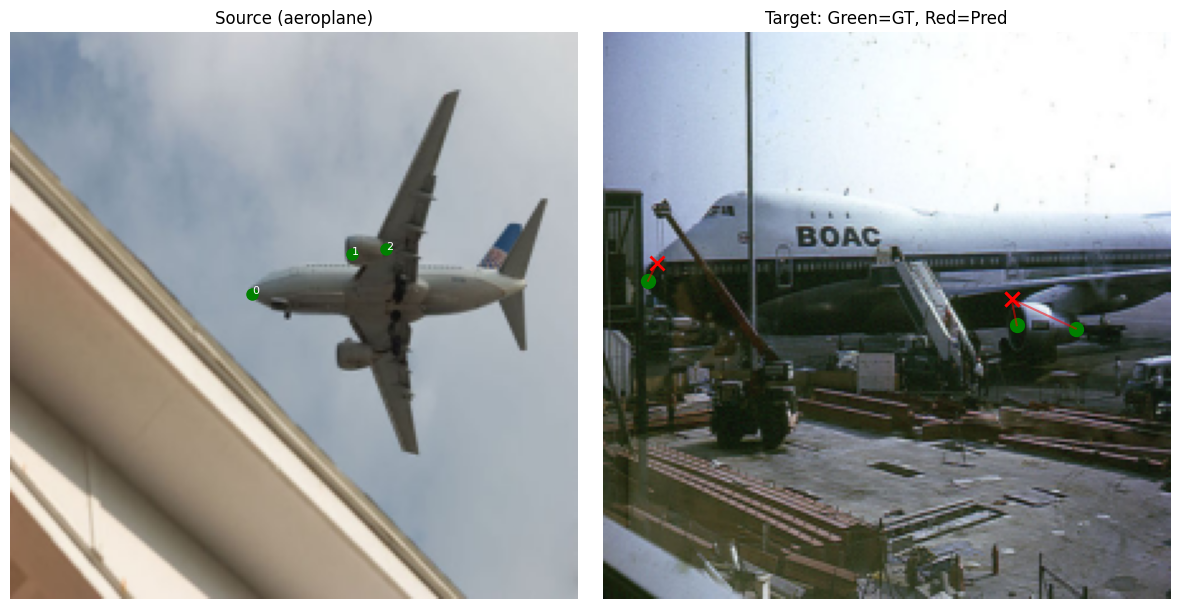

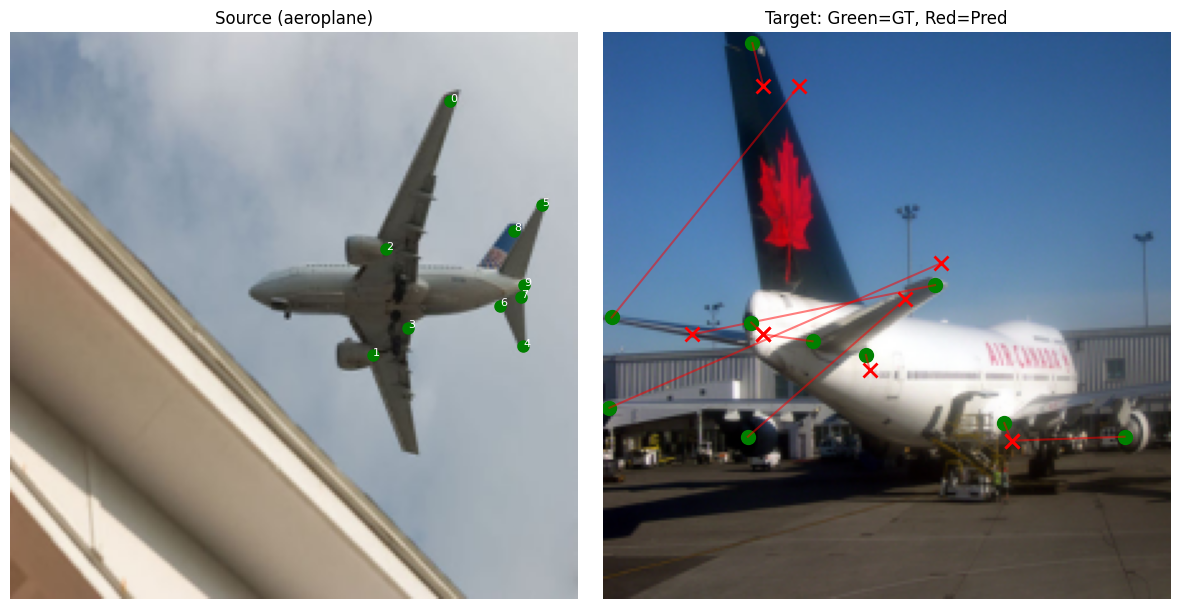

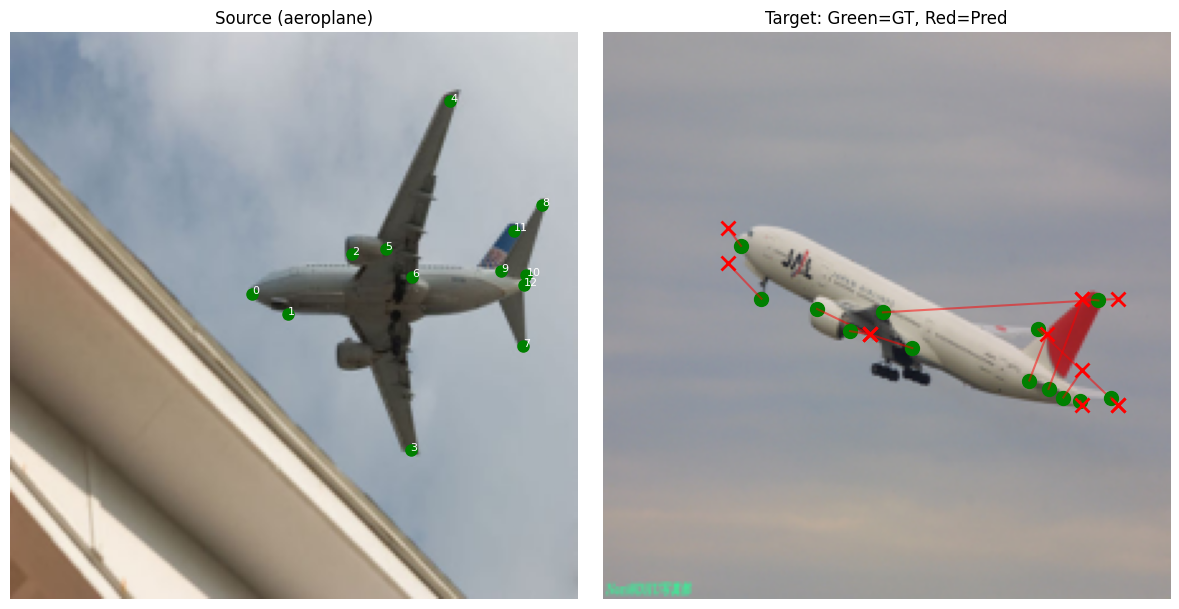

In [13]:
def visualize_correspondence(dataset, predictions, ground_truth, idx):
    """
    Visualize correspondence predictions vs ground truth for a single sample.
    
    Shows:
    - Left: Source image with source keypoints (green)
    - Right: Target image with predicted (red) and ground truth (green) keypoints
    """
    sample = dataset[idx]
    pred_kps = predictions[idx]
    gt_kps = ground_truth[idx]
    valid = sample['valid']
    
    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    src_img = (sample['src_img'] * std + mean).permute(1, 2, 0).numpy()
    tgt_img = (sample['tgt_img'] * std + mean).permute(1, 2, 0).numpy()
    src_img = np.clip(src_img, 0, 1)
    tgt_img = np.clip(tgt_img, 0, 1)
    
    src_kps = sample['src_kps'].numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Source image
    axes[0].imshow(src_img)
    axes[0].set_title(f"Source ({sample['category']})")
    
    # Target image
    axes[1].imshow(tgt_img)
    axes[1].set_title(f"Target: Green=GT, Red=Pred")
    
    # Plot keypoints
    for k in range(len(src_kps)):
        if not valid[k]:
            continue
        
        # Source keypoint
        axes[0].plot(src_kps[k, 0], src_kps[k, 1], 'go', markersize=8)
        axes[0].annotate(str(k), (src_kps[k, 0], src_kps[k, 1]), fontsize=8, color='white')
        
        # Ground truth keypoint (green)
        gt_pt = gt_kps[k].numpy()
        axes[1].plot(gt_pt[0], gt_pt[1], 'go', markersize=10)
        
        # Predicted keypoint (red)
        pred_pt = pred_kps[k].numpy()
        axes[1].plot(pred_pt[0], pred_pt[1], 'rx', markersize=10, markeredgewidth=2)
        
        # Line connecting prediction to ground truth
        axes[1].plot([gt_pt[0], pred_pt[0]], [gt_pt[1], pred_pt[1]], 'r-', alpha=0.5)
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


# Load dataset for visualization
viz_dataset = SPairDataset(
    CONFIG['dataset_path'],
    split='test',
    image_size=CONFIG['image_size'],
    max_samples=CONFIG['max_samples']
)

print("\n" + "=" * 60)
print("VISUALIZATION (Baseline)")
print("=" * 60)

# Visualize a few examples
for i in range(min(3, len(viz_dataset))):
    visualize_correspondence(viz_dataset, results_baseline['predictions'], results_baseline['ground_truth'], i)

---

# AdaptFormer Extension

**AdaptFormer** is a parameter-efficient fine-tuning method that adds lightweight adapter modules to frozen Transformer blocks. Instead of fine-tuning the entire backbone, we:

1. Keep DINOv2 completely frozen
2. Insert AdaptFormer modules in the last N transformer blocks
3. Train only the AdaptFormer parameters (~1-2% of total params)


The adapter is inserted **after the MLP** in each transformer block.

## AdaptFormer Module Definition

In [ ]:
class AdaptFormer(nn.Module):
    """
    AdaptFormer: Lightweight adapter module for Vision Transformers.
    
    Implements a bottleneck MLP that adapts frozen pre-trained features
    to downstream tasks with minimal parameters.
    
    Architecture:
        Input [N, D] → Down-proj [N, bottleneck] → ReLU → Up-proj [N, D] → Output
        Output = Input + scale * Adapter(Input)
    
    Args:
        d_model: Input/output feature dimension (e.g., 768 for DINOv2-base)
        bottleneck_dim: Bottleneck dimension (typically d_model // 4 or d_model // 8)
        dropout: Dropout probability (default: 0.0)
        init_scale: Initial scale for residual connection (default: 0.1)
    """
    
    def __init__(self, d_model, bottleneck_dim=64, dropout=0.0, init_scale=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.bottleneck_dim = bottleneck_dim
        
        # Down-projection: D → bottleneck_dim
        self.down_proj = nn.Linear(d_model, bottleneck_dim)
        
        # Non-linearity
        self.activation = nn.ReLU()
        
        # Up-projection: bottleneck_dim → D
        self.up_proj = nn.Linear(bottleneck_dim, d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Learnable scale parameter (initialized small for stable training)
        self.scale = nn.Parameter(torch.ones(1) * init_scale)
        
        # Initialize weights (small random values for stable training)
        self._init_weights()
    
    def _init_weights(self):
        """Initialize adapter weights with small random values."""
        nn.init.xavier_uniform_(self.down_proj.weight)
        nn.init.zeros_(self.down_proj.bias)
        
        # Initialize up-projection near zero for identity initialization
        nn.init.xavier_uniform_(self.up_proj.weight, gain=1e-3)
        nn.init.zeros_(self.up_proj.bias)
    
    def forward(self, x):
        """
        Forward pass with residual connection.
        
        Args:
            x: [B, N, D] input features (B=batch, N=seq_len, D=feature_dim)
        
        Returns:
            output: [B, N, D] adapted features
        """
        # Store input for residual connection
        residual = x
        
        # Adapter: down → ReLU → up → dropout
        x = self.down_proj(x)       # [B, N, D] → [B, N, bottleneck]
        x = self.activation(x)       # ReLU
        x = self.up_proj(x)          # [B, N, bottleneck] → [B, N, D]
        x = self.dropout(x)          # Dropout
        
        # Residual connection with learnable scale
        output = residual + self.scale * x
        
        return output


print("✓ AdaptFormer module defined")

## Inject AdaptFormer into DINOv2 Blocks

In [ ]:
def inject_adaptformer(model, bottleneck_dim=64, num_blocks=4, dropout=0.0):
    """
    Inject AdaptFormer modules into the last N transformer blocks of DINOv2.
    
    The adapter is inserted after the MLP (feed-forward network) in each block.
    We use forward hooks to intercept and modify the block output.
    
    Args:
        model: DINOv2 model
        bottleneck_dim: Bottleneck dimension for AdaptFormer
        num_blocks: Number of blocks from the end to add adapters to
        dropout: Dropout probability for adapters
    
    Returns:
        model: Modified model with AdaptFormer modules
        adapters: List of AdaptFormer modules (for accessing parameters)
    """
    total_blocks = len(model.blocks)
    start_idx = max(0, total_blocks - num_blocks)
    
    print(f"Injecting AdaptFormer into blocks {start_idx} to {total_blocks-1}")
    print(f"  Bottleneck dimension: {bottleneck_dim}")
    print(f"  Dropout: {dropout}")
    
    # Get feature dimension from the first block
    d_model = model.blocks[0].mlp.fc1.in_features
    print(f"  Feature dimension: {d_model}")
    
    adapters = []
    
    for block_idx in range(start_idx, total_blocks):
        block = model.blocks[block_idx]
        
        # Create AdaptFormer module
        adapter = AdaptFormer(
            d_model=d_model,
            bottleneck_dim=bottleneck_dim,
            dropout=dropout
        )
        
        # Move to same device as model
        adapter = adapter.to(next(model.parameters()).device)
        
        # Store adapter as a module attribute (important for state_dict)
        setattr(block, f'adaptformer', adapter)
        
        # Create forward hook that applies adapter after MLP
        def make_hook(adapter_module):
            def hook(module, input, output):
                """
                Hook that applies AdaptFormer after the transformer block.
                
                DINOv2 block output is just the features tensor.
                We apply the adapter and return the modified features.
                """
                # output is [B, N, D] where N = num_patches + 1 (includes CLS token)
                return adapter_module(output)
            return hook
        
        # Register the hook
        block.register_forward_hook(make_hook(adapter))
        
        adapters.append(adapter)
    
    print(f"\n✓ Injected {len(adapters)} AdaptFormer modules")
    
    # Count parameters
    adapter_params = sum(p.numel() for adapter in adapters for p in adapter.parameters())
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"  Adapter parameters: {adapter_params:,}")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Adapter ratio: {100 * adapter_params / total_params:.2f}%")
    
    return model, adapters


print("✓ AdaptFormer injection function defined")

## Freeze DINOv2 and Enable Only AdaptFormer

In [ ]:
def freeze_backbone_enable_adapters(model):
    """
    Freeze all DINOv2 parameters and enable only AdaptFormer modules.
    
    This ensures that:
    - Pre-trained DINOv2 weights remain unchanged
    - Only adapter modules are trained
    - Minimal memory and computation overhead
    
    Args:
        model: DINOv2 model with injected AdaptFormer modules
    
    Returns:
        model: Model with updated requires_grad settings
    """
    print("Setting trainable parameters...")
    
    # First, freeze ALL parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Then, unfreeze only AdaptFormer parameters
    num_trainable = 0
    for block in model.blocks:
        if hasattr(block, 'adaptformer'):
            for param in block.adaptformer.parameters():
                param.requires_grad = True
                num_trainable += param.numel()
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n✓ Trainable parameters: {trainable_params:,} / {total_params:,}")
    print(f"  ({100 * trainable_params / total_params:.2f}% of total)")
    
    return model


print("✓ Freeze/unfreeze function defined")

## AdaptFormer Configuration

In [ ]:
# AdaptFormer-specific configuration
ADAPTFORMER_CONFIG = {
    # AdaptFormer architecture
    'bottleneck_dim': 64,           # Bottleneck dimension (64 or 128 typical)
    'num_adapter_blocks': 4,        # Add adapters to last N blocks
    'adapter_dropout': 0.1,         # Dropout in adapters
    
    # Training data
    'use_small_split': True,
    'max_train_samples': None,
    
    # Training hyperparameters
    'learning_rate': 1e-3,          # Higher LR for adapters, since they start from scratch
    'epochs': 3,
    'batch_size': 8,
    'temperature': 0.1,             # Temperature for softmax
    'weight_decay': 0.01,           # L2 regularization
    'label_smoothing': 0.1,         # Label smoothing
    
    # Regularization
    'warmup_steps': 100,            # Learning rate warmup
    'max_grad_norm': 1.0,           # Gradient clipping
    
    # Data augmentation
    'use_augmentation': True,
    'horizontal_flip_prob': 0.5,
    'color_jitter': 0.2,
    
    # Early stopping
    'use_early_stopping': True,
    'patience': 2,                  # Stop after N epochs without improvement
    'min_delta': 0.001,             # Minimum improvement threshold
    
    'device': CONFIG['device']
}

print("AdaptFormer Configuration:")
for k, v in ADAPTFORMER_CONFIG.items():
    print(f"  {k}: {v}")

## Training Function for AdaptFormer

In [ ]:
def correspondence_loss(src_feats, tgt_feats, src_kps, tgt_kps, valid, temperature=0.1, label_smoothing=0.0):
    """
    Compute correspondence loss using cross-entropy over spatial positions.
    
    For each source keypoint:
    1. Extract its feature vector
    2. Compute similarity to all target positions
    3. Apply softmax and cross-entropy loss with ground truth target position
    
    Args:
        src_feats: [B, H, W, D] source features (L2-normalized)
        tgt_feats: [B, H, W, D] target features (L2-normalized)
        src_kps: List of [N, 2] source keypoint coordinates (x, y)
        tgt_kps: List of [N, 2] target keypoint coordinates (x, y)
        valid: List of [N] boolean masks for valid keypoint pairs
        temperature: Temperature for softmax (lower = sharper distribution)
        label_smoothing: Amount of label smoothing (0 = no smoothing)
    
    Returns:
        loss: Scalar loss value
    """
    B, H, W, D = src_feats.shape
    patch_size = CONFIG['patch_size']
    
    total_loss = 0.0
    num_valid_samples = 0
    
    for b in range(B):
        # Step 1: Get valid keypoints for this batch item
        mask = valid[b]  # [N] boolean mask
        if not mask.any():
            continue  # Skip if no valid keypoints
        
        src_kp = src_kps[b][mask]  # [N_valid, 2] - valid source keypoints
        tgt_kp = tgt_kps[b][mask]  # [N_valid, 2] - valid target keypoints
        
        # Step 2: Convert pixel coordinates to grid coordinates
        # Pixel coord (0-223) -> Grid coord (0-15)
        # We divide by patch_size (14) and clamp to valid range
        
        src_grid = (src_kp / patch_size).long()  # [N_valid, 2]
        tgt_grid = (tgt_kp / patch_size).long()  # [N_valid, 2]
        
        # Clamp to valid grid range [0, 15]
        src_grid[:, 0] = torch.clamp(src_grid[:, 0], 0, W - 1)  # x -> column
        src_grid[:, 1] = torch.clamp(src_grid[:, 1], 0, H - 1)  # y -> row
        tgt_grid[:, 0] = torch.clamp(tgt_grid[:, 0], 0, W - 1)
        tgt_grid[:, 1] = torch.clamp(tgt_grid[:, 1], 0, H - 1)
        
        # Step 3: Flatten feature maps for efficient computation
        # Reshape from [H, W, D] to [H*W, D] for matrix multiplication
        src_flat = src_feats[b].reshape(-1, D)  # [256, 768]
        tgt_flat = tgt_feats[b].reshape(-1, D)  # [256, 768]
        
        # Step 4: Convert 2D grid coordinates to 1D indices
        # Index = row * width + column = y * W + x
        src_indices = src_grid[:, 1] * W + src_grid[:, 0]  # [N_valid]
        tgt_indices = tgt_grid[:, 1] * W + tgt_grid[:, 0]  # [N_valid]
        
        # Step 5: Extract source keypoint features
        src_vecs = src_flat[src_indices]  # [N_valid, 768]
        
        # Step 6: Compute similarity scores (logits)
        # For each source keypoint, compute similarity to ALL target positions
        # Since features are L2-normalized, dot product = cosine similarity
        # Divide by temperature to control sharpness of distribution
        
        logits = torch.matmul(src_vecs, tgt_flat.T) / temperature  # [N_valid, 256]
        
        # Step 7: Apply cross-entropy loss
        # target_indices tells us which of the 256 positions is correct
        # Cross-entropy encourages high probability for correct position
        
        loss = F.cross_entropy(
            logits,           # [N_valid, 256] - predicted scores
            tgt_indices,      # [N_valid] - ground truth class (position)
            label_smoothing=label_smoothing
        )
        
        total_loss += loss
        num_valid_samples += 1
    
    # Average loss across batch items
    if num_valid_samples > 0:
        return total_loss / num_valid_samples
    else:
        return torch.tensor(0.0, device=src_feats.device, requires_grad=True)


print("✓ Correspondence loss function defined")

In [ ]:
def train_adaptformer():
    """
    Train DINOv2 with AdaptFormer modules for semantic correspondence.
    
    The entire DINOv2 backbone stays frozen, only AdaptFormer modules are trained.
    
    Returns:
        model: Model with trained AdaptFormer modules
        history: Dict with training and validation losses
    """
    print("\n" + "=" * 70)
    print("ADAPTFORMER TRAINING")
    print("=" * 70)
    
    # Load fresh DINOv2 model
    model = load_dinov2(CONFIG['backbone_size'], CONFIG['device'])
    
    # Inject AdaptFormer modules
    model, adapters = inject_adaptformer(
        model,
        bottleneck_dim=ADAPTFORMER_CONFIG['bottleneck_dim'],
        num_blocks=ADAPTFORMER_CONFIG['num_adapter_blocks'],
        dropout=ADAPTFORMER_CONFIG['adapter_dropout']
    )
    
    # Freeze backbone, enable only adapters
    model = freeze_backbone_enable_adapters(model)
    
    # Load datasets
    print("\nLoading datasets...")
    train_dataset = SPairDataset(
        CONFIG['dataset_path'],
        split='train',
        image_size=CONFIG['image_size'],
        max_samples=ADAPTFORMER_CONFIG['max_train_samples'],
        augment=ADAPTFORMER_CONFIG['use_augmentation'],
        use_small_split=ADAPTFORMER_CONFIG['use_small_split']
    )
    
    val_dataset = SPairDataset(
        CONFIG['dataset_path'],
        split='val',
        image_size=CONFIG['image_size'],
        augment=False,
        use_small_split=ADAPTFORMER_CONFIG['use_small_split']
    )
    
    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch]
        }
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=ADAPTFORMER_CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=ADAPTFORMER_CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )
    
    # Optimizer (only adapter parameters)
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=ADAPTFORMER_CONFIG['learning_rate'],
        weight_decay=ADAPTFORMER_CONFIG['weight_decay']
    )
    
    # Learning rate scheduler with warmup
    total_steps = len(train_loader) * ADAPTFORMER_CONFIG['epochs']
    warmup_steps = ADAPTFORMER_CONFIG['warmup_steps']
    
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return max(0.1, 1.0 - (step - warmup_steps) / (total_steps - warmup_steps))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Feature extractor
    extractor = FeatureExtractor(model, CONFIG['patch_size'], CONFIG['device'])
    
    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"\nTraining for up to {ADAPTFORMER_CONFIG['epochs']} epochs")
    print(f"Early stopping: patience={ADAPTFORMER_CONFIG['patience']}")
    print("-" * 70)
    
    for epoch in range(ADAPTFORMER_CONFIG['epochs']):
        # Training
        model.train()
        epoch_train_loss = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{ADAPTFORMER_CONFIG['epochs']} [Train]")
        for batch in pbar:
            optimizer.zero_grad()
            
            src_img = batch['src_img'].to(CONFIG['device'])
            tgt_img = batch['tgt_img'].to(CONFIG['device'])
            src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
            valid = [v.to(CONFIG['device']) for v in batch['valid']]
            
            # Extract features (use None for final layer)
            src_feats = extractor.extract(src_img, layer_idx=None)
            tgt_feats = extractor.extract(tgt_img, layer_idx=None)
            
            # Compute loss
            loss = correspondence_loss(
                src_feats, tgt_feats,
                src_kps, tgt_kps, valid,
                temperature=ADAPTFORMER_CONFIG['temperature'],
                label_smoothing=ADAPTFORMER_CONFIG['label_smoothing']
            )
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                filter(lambda p: p.requires_grad, model.parameters()),
                ADAPTFORMER_CONFIG['max_grad_norm']
            )
            
            optimizer.step()
            scheduler.step()
            
            epoch_train_loss.append(loss.item())
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        avg_train_loss = sum(epoch_train_loss) / len(epoch_train_loss)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        epoch_val_loss = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{ADAPTFORMER_CONFIG['epochs']} [Val]", leave=False):
                src_img = batch['src_img'].to(CONFIG['device'])
                tgt_img = batch['tgt_img'].to(CONFIG['device'])
                src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
                tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
                valid = [v.to(CONFIG['device']) for v in batch['valid']]
                
                src_feats = extractor.extract(src_img, layer_idx=None)
                tgt_feats = extractor.extract(tgt_img, layer_idx=None)
                
                loss = correspondence_loss(
                    src_feats, tgt_feats,
                    src_kps, tgt_kps, valid,
                    temperature=ADAPTFORMER_CONFIG['temperature'],
                    label_smoothing=0.0
                )
                epoch_val_loss.append(loss.item())
        
        avg_val_loss = sum(epoch_val_loss) / len(epoch_val_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}")
        
        # Early Stopping
        if ADAPTFORMER_CONFIG['use_early_stopping']:
            if avg_val_loss < best_val_loss - ADAPTFORMER_CONFIG['min_delta']:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                print(f"  → New best model (val_loss={best_val_loss:.4f})")
            else:
                patience_counter += 1
                print(f"  → No improvement ({patience_counter}/{ADAPTFORMER_CONFIG['patience']})")
                
                if patience_counter >= ADAPTFORMER_CONFIG['patience']:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Restored best model (val_loss={best_val_loss:.4f})")
    
    print("\n" + "=" * 70)
    print("ADAPTFORMER TRAINING COMPLETE")
    print("=" * 70)
    
    return model, {'train': train_losses, 'val': val_losses}


print("✓ AdaptFormer training function defined")

---

# Run AdaptFormer Training and Evaluation

## Train AdaptFormer Model

In [ ]:
# Run AdaptFormer training
adaptformer_model, adaptformer_history = train_adaptformer()

# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))

epochs_range = range(1, len(adaptformer_history['train']) + 1)
ax.plot(epochs_range, adaptformer_history['train'], 'b-o', label='Train Loss', linewidth=2)
ax.plot(epochs_range, adaptformer_history['val'], 'r-s', label='Val Loss', linewidth=2)

ax.set_title("AdaptFormer Training Loss Curves", fontsize=14)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Train Loss: {adaptformer_history['train'][-1]:.4f}")
print(f"Final Val Loss: {adaptformer_history['val'][-1]:.4f}")
print(f"Best Val Loss: {min(adaptformer_history['val']):.4f}")

## Save AdaptFormer Model

In [ ]:
# Save AdaptFormer model
def save_adaptformer_model(model, history, save_dir=None):
    """
    Save trained AdaptFormer model to disk.
    
    Saves only the adapter parameters (not the full DINOv2 backbone)
    along with training metadata.
    
    Args:
        model: Model with trained AdaptFormer modules
        history: Training history dict
        save_dir: Directory to save to (defaults to DRIVE_ROOT/checkpoints/AdaptFormer)
    
    Returns:
        Path to saved checkpoint
    """
    if save_dir is None:
        save_dir = DRIVE_ROOT / 'checkpoints' / 'AdaptFormer'
    
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Create timestamp-based filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_name = f"adaptformer_dinov2_{CONFIG['backbone_size']}_{timestamp}.pth"
    checkpoint_path = save_dir / checkpoint_name
    
    # Extract only adapter parameters
    adapter_state_dict = {}
    for name, param in model.named_parameters():
        if 'adaptformer' in name.lower():
            adapter_state_dict[name] = param.cpu()
    
    # Prepare checkpoint data
    checkpoint = {
        'adapter_state_dict': adapter_state_dict,
        'history': history,
        'config': ADAPTFORMER_CONFIG.copy(),
        'backbone_config': {
            'backbone_size': CONFIG['backbone_size'],
            'patch_size': CONFIG['patch_size'],
            'image_size': CONFIG['image_size']
        },
        'timestamp': timestamp,
        'best_val_loss': min(history['val']) if history['val'] else float('inf'),
        'final_train_loss': history['train'][-1] if history['train'] else None,
        'final_val_loss': history['val'][-1] if history['val'] else None
    }
    
    # Save checkpoint
    torch.save(checkpoint, checkpoint_path)
    
    print("\n" + "=" * 70)
    print("✓ AdaptFormer model saved!")
    print("=" * 70)
    print(f"Checkpoint path: {checkpoint_path}")
    print(f"Adapter parameters: {len(adapter_state_dict)}")
    print(f"Best val loss: {checkpoint['best_val_loss']:.4f}")
    print(f"Timestamp: {timestamp}")
    print("=" * 70)
    
    return checkpoint_path

# Save the trained model
checkpoint_path = save_adaptformer_model(adaptformer_model, adaptformer_history)


## Load AdaptFormer Model

In [ ]:
# Load AdaptFormer model from checkpoint
def load_adaptformer_model(checkpoint_path=None, load_dir=None):
    """
    Load a saved AdaptFormer model from checkpoint.
    
    Args:
        checkpoint_path: Full path to checkpoint file (if None, loads latest)
        load_dir: Directory to search for checkpoints (defaults to DRIVE_ROOT/checkpoints/AdaptFormer)
    
    Returns:
        model: DINOv2 model with loaded AdaptFormer parameters
        checkpoint: Full checkpoint data (includes history, config, etc.)
    """
    if load_dir is None:
        load_dir = DRIVE_ROOT / 'checkpoints' / 'AdaptFormer'
    
    # If no specific checkpoint path provided, find the latest one
    if checkpoint_path is None:
        checkpoints = sorted(load_dir.glob('adaptformer_*.pth'))
        if not checkpoints:
            raise FileNotFoundError(f"No AdaptFormer checkpoints found in {load_dir}")
        checkpoint_path = checkpoints[-1]  # Most recent
        print(f"Loading latest checkpoint: {checkpoint_path.name}")
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    print("\n" + "=" * 70)
    print("Loading AdaptFormer checkpoint")
    print("=" * 70)
    print(f"Checkpoint: {checkpoint_path.name}")
    print(f"Timestamp: {checkpoint.get('timestamp', 'N/A')}")
    print(f"Best val loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")
    print(f"Backbone: DINOv2-{checkpoint['backbone_config']['backbone_size']}")
    
    # Load fresh DINOv2 model
    model = load_dinov2(
        checkpoint['backbone_config']['backbone_size'],
        CONFIG['device']
    )
    
    # Inject AdaptFormer modules with same architecture as checkpoint
    saved_config = checkpoint['config']
    model, adapters = inject_adaptformer(
        model,
        bottleneck_dim=saved_config['bottleneck_dim'],
        num_blocks=saved_config['num_adapter_blocks'],
        dropout=saved_config['adapter_dropout']
    )
    
    # Load adapter parameters
    adapter_state_dict = checkpoint['adapter_state_dict']
    
    # Match parameters to model
    model_dict = model.state_dict()
    matched = 0
    for name, param in adapter_state_dict.items():
        if name in model_dict:
            model_dict[name] = param.to(CONFIG['device'])
            matched += 1
    
    model.load_state_dict(model_dict)
    
    print(f"Loaded {matched}/{len(adapter_state_dict)} adapter parameters")
    print("=" * 70 + "\n")
    
    return model, checkpoint


# Load from latest checkpoint
# Uncomment to load instead of using the just-trained model:
# adaptformer_model, checkpoint = load_adaptformer_model()
# adaptformer_history = checkpoint['history']


print("✓ AdaptFormer load function ready (uncomment to use)")


## Evaluate AdaptFormer Model

In [ ]:
# Create a modified config for AdaptFormer evaluation (use final layer)
ADAPTFORMER_EVAL_CONFIG = CONFIG.copy()
ADAPTFORMER_EVAL_CONFIG['feature_layer'] = None  # Use final layer output

print("Evaluating AdaptFormer model (using final layer)...")
results_adaptformer = evaluate(adaptformer_model, ADAPTFORMER_EVAL_CONFIG, tag='adaptformer', use_cache=False)

## Visualize AdaptFormer Results

In [ ]:
# =============================================================================
# VISUALIZATION: AdaptFormer Results
# =============================================================================

# Extract PCK values across thresholds for AdaptFormer
af_pck = [results_adaptformer['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]

# Plot 1: PCK across thresholds
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(CONFIG['pck_thresholds'], af_pck, 'g-^', label='AdaptFormer', linewidth=2, markersize=10)

ax.set_title("AdaptFormer PCK Across Thresholds", fontsize=14, fontweight='bold')
ax.set_xlabel("PCK Threshold", fontsize=12)
ax.set_ylabel("PCK (%)", fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Per-category PCK@0.1
categories = sorted(results_adaptformer['categories'].keys())
cat_pck = [results_adaptformer['categories'][cat]['PCK@0.1'] for cat in categories]

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(range(len(categories)), cat_pck, color='green', alpha=0.7)

ax.set_title("AdaptFormer Per-Category PCK@0.1", fontsize=14, fontweight='bold')
ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("PCK@0.1 (%)", fontsize=12)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels([c[:4] for c in categories], rotation=45, ha='right')
ax.axhline(y=results_adaptformer['overall']['PCK@0.1'], color='red', linestyle='--', 
           label=f"Overall: {results_adaptformer['overall']['PCK@0.1']:.1f}%")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Plot 3: Training curves
fig, ax = plt.subplots(figsize=(10, 6))

af_epochs = range(1, len(adaptformer_history['train']) + 1)
ax.plot(af_epochs, adaptformer_history['train'], 'b-o', label='Train Loss', linewidth=2, markersize=8)
ax.plot(af_epochs, adaptformer_history['val'], 'r-s', label='Val Loss', linewidth=2, markersize=8)

ax.set_title("AdaptFormer Training Curves", fontsize=14, fontweight='bold')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ADAPTFORMER RESULTS SUMMARY")
print("=" * 70)
print(f"Overall PCK@0.1: {results_adaptformer['overall']['PCK@0.1']:.2f}%")
print(f"Mean Per-Image PCK@0.1: {results_adaptformer['mean_per_image']['PCK@0.1']:.2f}%")
print(f"Best val loss: {min(adaptformer_history['val']):.4f}")
print(f"Final train loss: {adaptformer_history['train'][-1]:.4f}")
print("=" * 70)


## Save AdaptFormer Results to CSV

In [ ]:
# Save AdaptFormer results to CSV files
def save_adaptformer_results(results, save_dir=None):
    """
    Save AdaptFormer evaluation results to CSV files.
    
    Args:
        results: Results dictionary from evaluate()
        save_dir: Directory to save to (defaults to DRIVE_ROOT/results/AdaptFormer)
    
    Returns:
        Tuple of (overall_path, categories_path)
    """
    if save_dir is None:
        save_dir = DRIVE_ROOT / 'results' / 'AdaptFormer'
    
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Since AdaptFormer uses the final layer (no specific layer number),
    # we use "final" in the filename
    overall_filename = "dinov2_adaptformer_layerFinal_overall.csv"
    categories_filename = "dinov2_adaptformer_layerFinal_categories.csv"
    
    overall_path = save_dir / overall_filename
    categories_path = save_dir / categories_filename
    
    # =========================================================================
    # 1. Save Overall Results (including mean per-image)
    # =========================================================================
    overall_data = []
    
    # Add overall metrics (aggregated across all keypoints)
    for threshold, pck in results['overall'].items():
        overall_data.append({
            'Metric': f'{threshold} (overall)',
            'Value': f'{pck:.2f}%'
        })
    
    # Add mean per-image metrics
    for threshold, pck in results['mean_per_image'].items():
        overall_data.append({
            'Metric': f'{threshold} (mean per-image)',
            'Value': f'{pck:.2f}%'
        })
    
    overall_df = pd.DataFrame(overall_data)
    overall_df.to_csv(overall_path, index=False)
    
    # =========================================================================
    # 2. Save Per-Category Results
    # =========================================================================
    categories_data = []
    
    for category, metrics in sorted(results['categories'].items()):
        row = {'Category': category}
        for threshold, pck in metrics.items():
            row[threshold] = f'{pck:.2f}%'
        categories_data.append(row)
    
    categories_df = pd.DataFrame(categories_data)
    categories_df.to_csv(categories_path, index=False)
    
    # Print confirmation
    print("\n" + "=" * 70)
    print("✓ AdaptFormer results saved to CSV")
    print("=" * 70)
    print(f"Overall results: {overall_path}")
    print(f"Category results: {categories_path}")
    print(f"Total categories: {len(results['categories'])}")
    print("=" * 70 + "\n")
    
    return overall_path, categories_path


# Save the results
overall_csv, categories_csv = save_adaptformer_results(results_adaptformer)
